# **Segundo conjunto de tareas a realizar**

## Paquetes necesarios e inicializaciones

Para la realización de las siguientes tareas, se va a utilizar el mismo *enviroment* de Python llamado VC_P1 creado en el [primer conjunto de tareas](../VC_P1/Exercises_P1.ipynb), la única dependencia adicional que se ha de descargar es la que viene dada por el paquete **Pillow**.

Adicionalmente, se va a cargar la [imagen](../VC_P2/Resources/mandril.jpg) a utilizar en las posteriores tareas, de forma que no sea necesario cargarla en cada uno de los ejercicios en donde se requiera su uso.

Por último antes de empezar, se van a inicializar todos los paquetes requeridos para la correcta ejecución de los ejercicios.

In [25]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

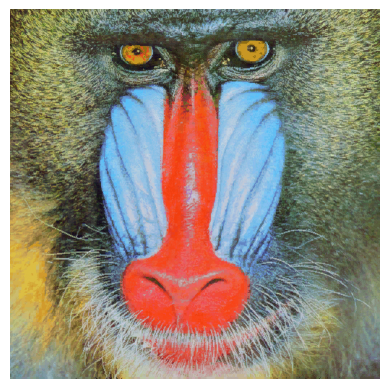

La imagen tiene un tamaño de 512x512 pixeles


In [ ]:
image = cv2.imread('Resources/mandril.jpg') 

if image is not None:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.axis("off")
    plt.imshow(image_rgb) 
    plt.show()
    heigth, width = image.shape[:2]
    print(f'La imagen tiene un tamaño de {width}x{heigth} píxeles')
else: 
    print('Imagen no encontrada')

Para las tareas también va a ser de gran utilidad poseer la imagen en escala de grises, por lo tanto, se va a obtener la misma.

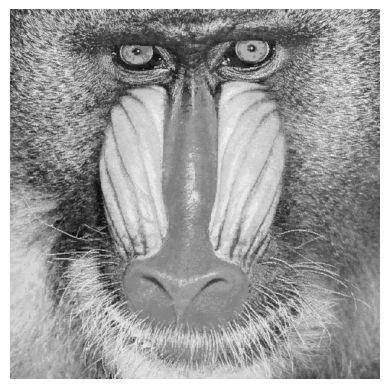

In [27]:
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.axis("off")
plt.imshow(gray_img, cmap='gray') 
plt.show()

## Número máximo de píxeles blancos

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

maxfil (máximo de píxeles blancos en una fila): 220
Número de filas con píxeles >= 0.90*maxfil: 7
Posiciones de las filas (índice 0-based): [6, 12, 15, 20, 21, 88, 100]
Posiciones de las filas (1-based): [7, 13, 16, 21, 22, 89, 101]


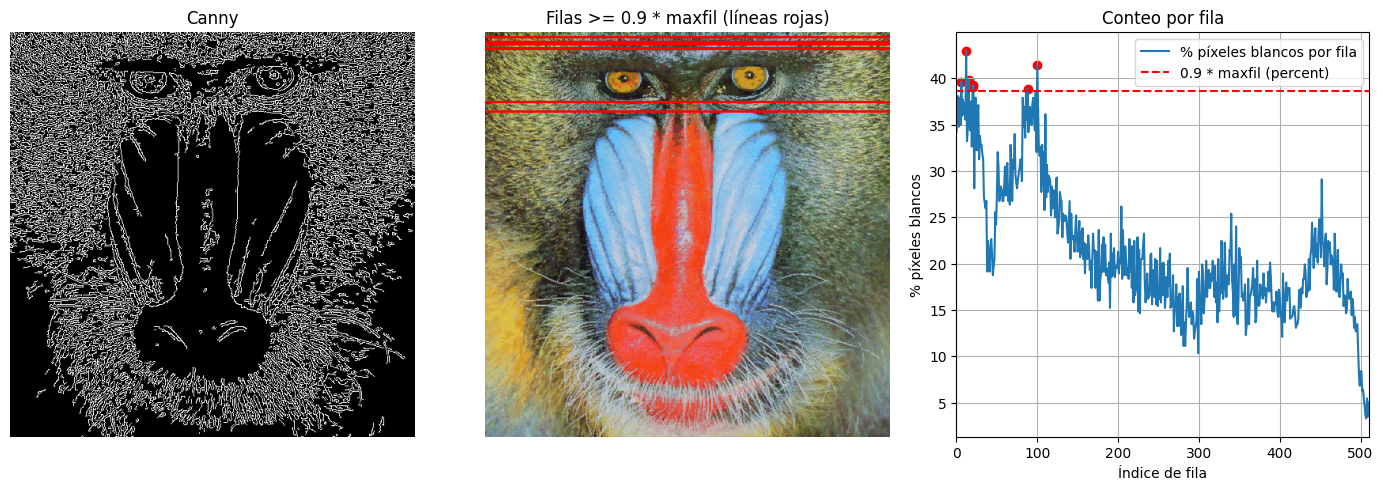

In [28]:
canny = cv2.Canny(gray_img, 100, 200)

row_sums = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
white_per_row = (row_sums.flatten() // 255).astype(int)

maxfil = int(white_per_row.max())
print(f"maxfil (máximo de píxeles blancos en una fila): {maxfil}")

if maxfil == 0:
    print("Atención: no hay píxeles blancos (maxfil = 0).")
    rows_meeting = np.array([], dtype=int)
else:
    threshold = 0.9 * maxfil
    rows_meeting = np.where(white_per_row >= threshold)[0]
    print(f"Número de filas con píxeles >= 0.90*maxfil: {rows_meeting.size}")
    print("Posiciones de las filas (índice 0-based):", rows_meeting.tolist())
    print("Posiciones de las filas (1-based):", (rows_meeting + 1).tolist())

overlay = image_rgb.copy()
height, width = canny.shape
for r in rows_meeting:
    cv2.line(overlay, (0, r), (width - 1, r), (255, 0, 0), 2)  # rojo en RGB

percent_per_row = white_per_row / width * 100

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.imshow(canny, cmap='gray')
plt.title('Canny')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title('Filas >= 0.9 * maxfil (líneas rojas)')
plt.axis('off')

plt.subplot(1, 3, 3)
x = np.arange(len(percent_per_row))
plt.plot(x, percent_per_row, label='% píxeles blancos por fila')
if maxfil != 0:
    thr_percent = (threshold / width) * 100
    plt.axhline(thr_percent, color='r', linestyle='--', label='0.9 * maxfil (percent)')
    plt.scatter(rows_meeting, percent_per_row[rows_meeting], color='red')

plt.xlabel('Índice de fila')
plt.ylabel('% píxeles blancos')
plt.title('Conteo por fila')
plt.legend()
plt.grid(True)
plt.xlim([0, len(percent_per_row)-1])

plt.tight_layout()
plt.show()


## Umbralizado de imagen a 8 bits

Se va a aplicar un umbralizado de la imagen del [mandril](../VC_P2/Resources/mandril.jpg) tras pasarla a escala de grises y posteriormente, se va a realizar el conteo por filas y columnas. Adicionalmente, se va a mostrar el dato del valor máximo de las filas y columnas, además de determinar las mismas que tengan un valor por encima del 90% del máximo.

Por último, se usa la imagen del [mandril](../VC_P2/Resources/mandril.jpg) para mostrar las filas y columnas obtenidas tras realizar lo anterior mencionado usando la técnica de **[Sobel](https://scispace.com/pdf/edge-detection-by-modified-otsu-method-167ccq2st7.pdf)** y la técnica de **[Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)**.

La técnica del **[Sobel](https://scispace.com/pdf/edge-detection-by-modified-otsu-method-167ccq2st7.pdf)** consiste en detectar bordes más continuos y gruesos ya que calcula la magnitud del gradiente en todas las partes, a esto se le aplica el umbral **[Otsu](https://learnopencv.com/otsu-thresholding-with-opencv/)** el cual suele conservar bastantes transiciones de intensidad. 

Entre sus características destacan:

- Tiende a incluir bordes suaves y ruido (aunque no siempre son relevantes).

- Tanto las filas como las columnas seleccionadas abarcan zonas más amplias que, por ejemplo, la técnica Canny, esto es porque hay más píxeles por encima del umbral.

La técnica **[Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)**, a comparación de la anterior, detecta bordes mucho más delgados y definidos ya que no solo incluye el gradiente sino también una supresión de histéresis con dos umbrales y máximos.

Entre sus características destacan:

- Es más selectivo, descartando transiciones débiles y ruido.

- Las filas y columnas seleccionadas suelen ser menos numerosas pero más precisas y se alinean más con los contornos más claros de la imagen.

------------ Sobel ------------
Valor máximo de filas: 356
Valor máximo de columnas: 289

------------ Canny ------------
Valor máximo de filas: 220
Valor máximo de columnas: 187


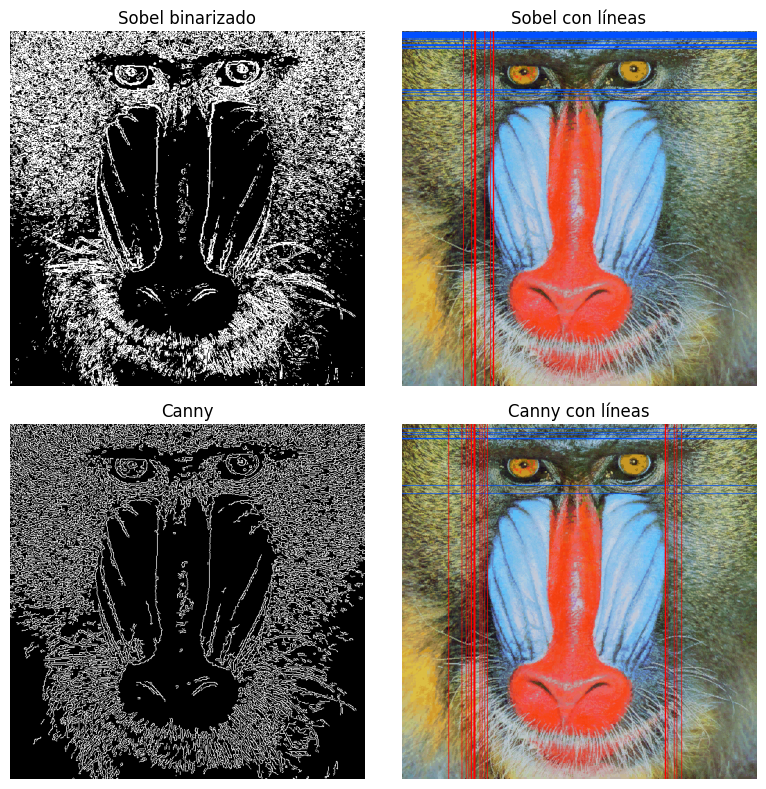

In [29]:
def show_maxs(name, cols, rows):
    print(f"------------ {name} ------------")
    print(f"Valor máximo de filas: {rows}")
    print(f"Valor máximo de columnas: {cols}")

def process_sobel(frame_gray, frame_rgb, show_values=False):
    sobelx = cv2.Sobel(frame_gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(frame_gray, cv2.CV_64F, 0, 1)
    sobel_magnitude = cv2.magnitude(sobelx, sobely)
    sobel = cv2.convertScaleAbs(sobel_magnitude)

    _, sobel_bin = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    row_counts = cv2.reduce(sobel_bin, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)[:, 0] // 255
    col_counts = cv2.reduce(sobel_bin, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)[0] // 255
    max_rows = np.max(row_counts)
    max_cols = np.max(col_counts)

    if show_values:
        show_maxs("Sobel", max_cols, max_rows)

    rows_selected = np.where(row_counts >= 0.9 * max_rows)[0]
    cols_selected = np.where(col_counts >= 0.9 * max_cols)[0]

    marked = frame_rgb.copy()
    for r in rows_selected:
        cv2.line(marked, (0, r), (marked.shape[1], r), (0, 80, 255), 1)
    for c in cols_selected:
        cv2.line(marked, (c, 0), (c, marked.shape[0]), (255, 0, 0), 1)

    return marked, sobel_bin

def process_canny(frame_gray, frame_rgb, show_values=False):
    canny = cv2.Canny(frame_gray, 100, 200)

    row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)[:, 0] // 255
    col_counts = cv2.reduce(canny, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)[0] // 255
    max_rows = np.max(row_counts)
    max_cols = np.max(col_counts)

    if show_values:
        show_maxs("Canny", max_cols, max_rows)

    rows_selected = np.where(row_counts >= 0.9 * max_rows)[0]
    cols_selected = np.where(col_counts >= 0.9 * max_cols)[0]

    marked = frame_rgb.copy()
    for r in rows_selected:
        cv2.line(marked, (0, r), (marked.shape[1], r), (0, 80, 255), 1)
    for c in cols_selected:
        cv2.line(marked, (c, 0), (c, marked.shape[0]), (255, 0, 0), 1)

    return marked, canny

sobel_marked, sobel_bin = process_sobel(gray_img, image_rgb, show_values=True)
print()
canny_marked, canny = process_canny(gray_img, image_rgb, show_values=True)

plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.title("Sobel binarizado")
plt.axis("off")
plt.imshow(sobel_bin, cmap="gray")

plt.subplot(2,2,2)
plt.title("Sobel con líneas")
plt.axis("off")
plt.imshow(sobel_marked)

plt.subplot(2,2,3)
plt.title("Canny")
plt.axis("off")
plt.imshow(canny, cmap="gray")

plt.subplot(2,2,4)
plt.title("Canny con líneas")
plt.axis("off")
plt.imshow(canny_marked)

plt.tight_layout()
plt.show()

## Modos de captura por WebCam

En esta tarea se propone un demostrador de los modos de detección de bordes aplicados en la tarea anterior, en este caso, se va a aplicar en las imágenes recogidas a través de la WebCam. Adicionalmente, se han aplicado diferentes modos de imagen adicionales. Los modos de imagen implementados son:

- **"o", original:** Es el modo de imagen por defecto que le entra a la WebCam.

- **"e", espejo:** Le da la vuelta a la imagen en el eje X, mostrando así la visión real que tiene una persona sobre la imagen.

- **"g", gris:** La imagen original que recibe como entrada la WebCam se pone en escala de grises.

- **"c", canny:** Convierte la imagen de entrada en una escala de blancos y grises para depsués de umbralizarla mostrar únicamente los bordes detectados.

- **"y", canny filas y columnas:** Usando el método para la obtención de las filas y columnas de modo canny creado para la tarea anterior, se aplica pero a la imagen de entrada de la WebCam.

- **"s", sobel:** Convierte la imagen de entrada en una escala de blancos y grises para después de umbralizarla mostrar únicamente los bordes detectados.

- **"x", sobel filas y columnas:** Usando el método para la obtención de filas y columnas de modo sobel creado para la tarea anterior, se aplica a la imagen de entrada de la WebCam.

- **"f", substracción de fondo:** Usando una cámara fija se construye un fondo sin demasiado movimiento y en cada iteración de la captura de fotogramas se compara si un pixel ha cambiado de estado y lo pone en blanco.

Para cambiar los modos de visualización, se ha de pulsar por teclado las teclas mecionadas en el menú de opciones que se printea al ejecutar el script inferior.

In [30]:
vid = cv2.VideoCapture(0)

backgroundOff = cv2.createBackgroundSubtractorMOG2(
    history=100, varThreshold=50, detectShadows=True)

def show_controls():
    print("----------- Controles -----------")
    print("o - Original")
    print("e - Espejo")
    print("g - Gris")
    print("c - Canny")
    print("y - Canny filas y columnas")
    print("s - Sobel")
    print("x - Sobel filas y columnas")
    print("f - Sustracción de fondo")
    print("ESC - Salir")

show_controls()

mode = "original"
while True:
    ret, frame = vid.read()
    if not ret:
        break

    if mode == "original":
        out = frame

    elif mode == "espejo":
        out = cv2.flip(frame, 1)

    elif mode == "gris":
        out = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)

    elif mode == "canny":
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        out = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    elif mode == "canny filas y columnas":
        marked, _ = process_sobel(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), frame)
        out = marked

    elif mode == "sobel":
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        sobel_mag = cv2.magnitude(sobelx, sobely)
        sobel = cv2.convertScaleAbs(sobel_mag)
        out = cv2.cvtColor(sobel, cv2.COLOR_GRAY2BGR)
    
    elif mode == "sobel filas y columnas":
        marcado, _ = process_canny(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), frame)
        out = marcado

    elif mode == "fondo":
        out = backgroundOff.apply(frame)
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2BGR)

    else:
        out = frame

    cv2.imshow("Demostrador Webcam", out)

    key = cv2.waitKey(20) & 0xFF
    if key == 27:
        break
    elif key == ord("o"):
        mode = "original"
    elif key == ord("e"):
        mode = "espejo"
    elif key == ord("g"):
        mode = "gris"
    elif key == ord("c"):
        mode = "canny"
    elif key == ord("s"):
        mode = "sobel"
    elif key == ord("f"):
        mode = "fondo"
    elif key == ord("y"):
        mode = "canny filas y columnas"
    elif key == ord("x"):
        mode = "sobel filas y columnas"

vid.release()
cv2.destroyAllWindows()

----------- Controles -----------
o - Original
e - Espejo
g - Gris
c - Canny
y - Canny filas y columnas
s - Sobel
x - Sobel filas y columnas
f - Sustracción de fondo
ESC - Salir


## Interactive Motion Art 

La tarea consiste en una instalación donde la cámara capta a la persona en tiempo real, detecta movimientos o cambios en la escena y genera un efecto visual dinámico basado en los bordes, colores y diferencias entre frames, creando una especie de *“pintura en tiempo real”* que refleja la interacción del espectador con el espacio. 

El código convierte los frames a escala de grises, aplica suavizado Gaussiano para reducir el ruido, calcula los bordes mediante el filtro Sobel y detecta movimiento comparando el frame actual con el anterior. En la ventana principal (demostrador interactivo), las zonas con movimiento se colorean en rojo y se superponen los bordes **[Sobel](https://scispace.com/pdf/edge-detection-by-modified-otsu-method-167ccq2st7.pdf)** para generar un efecto visual artístico. La ventana *"Movimiento"* muestra únicamente la máscara binaria del movimiento detectado entre frames consecutivos, mientras que la ventana *"Fondo"* presenta el modelo del fondo estimado por el background subtractor, permitiendo diferenciar claramente los objetos móviles del fondo estático. La ejecución se realiza en tiempo real y finaliza al pulsar la tecla ESC, liberando todos los recursos de la cámara.

In [31]:
vid = cv2.VideoCapture(0)

if not vid.isOpened():
    print("No se puede abrir la cámara")
    exit()

backgroundOff = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)

last_frame = None

cv2.namedWindow('Demostrador Interactivo', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Demostrador Interactivo', 640, 480)

cv2.namedWindow('Movimiento', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Movimiento', 320, 240)

cv2.namedWindow('Fondo', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Fondo', 320, 240)

while True:
    ret, frame = vid.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    light_gray = cv2.GaussianBlur(gray, (3, 3), 0)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    sobel = cv2.add(sobelx, sobely)
    sobel8 = cv2.convertScaleAbs(sobel)

    if last_frame is None:
        last_frame = light_gray.copy()
        movement = np.zeros_like(light_gray)
    else:
        movement = cv2.absdiff(light_gray, last_frame)
        last_frame = light_gray.copy()

    _, movement_bin = cv2.threshold(movement, 25, 255, cv2.THRESH_BINARY)

    color = cv2.cvtColor(light_gray, cv2.COLOR_GRAY2BGR)
    color[movement_bin > 0] = [0, 0, 255]
    color = cv2.addWeighted(color, 0.7, cv2.cvtColor(sobel8, cv2.COLOR_GRAY2BGR), 0.3, 0)

    background = backgroundOff.apply(frame)

    cv2.imshow('Demostrador Interactivo', color)
    cv2.imshow('Movimiento', movement_bin)
    cv2.imshow('Fondo', background)

    if cv2.waitKey(20) & 0xFF == 27:
        break

vid.release()
cv2.destroyAllWindows()

## Fuentes y Documentación

- **Internet:** Se ha utilizado internet para la búsqueda de información relativa al funcionamiento de la estrategia de **[Sobel](https://scispace.com/pdf/edge-detection-by-modified-otsu-method-167ccq2st7.pdf)**, aplicando también el **[Otsu](https://learnopencv.com/otsu-thresholding-with-opencv/)** y la estrategia de **[Canny](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)**. Adicionalmente, para la última tarea se ha tomado inspiración de los vídeos: [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared).

- **Inteligencia Artificial Generativa (ChatGPT):** Se ha utilizado la IA generativa para refactorizar el código de la [tarea 2](#umbralizado-de-imagen-a-8-bits) para convertirlo en una función con el objetivo de poder implementarla de manera simple como un modo adicional en la [tarea 3](#modos-de-captura-por-webcam).

- **Enlaces:**
    - https://scispace.com/pdf/edge-detection-by-modified-otsu-method-167ccq2st7.pdf
    - https://learnopencv.com/otsu-thresholding-with-opencv/
    - https://chatgpt.com/
    - https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
    - https://www.niklasroy.com/project/88/my-little-piece-of-privacy
    - https://youtu.be/GfoqiyB1ndE?feature=shared
    - https://youtu.be/FIAmyoEpV5c?feature=shared

Para más documentación referente a las tareas, véase el [README](./README.md) asociado a la carpeta de la práctica en cuestión **(VC_P2)**.